In [283]:
import re
from xml.etree import ElementTree

svg = ElementTree.parse('../data/argentinaHigh.svg')

provinces = ["Buenos Aires", "Catamarca", "Chaco", "Chubut", "Ciudad de Buenos Aires", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "Santa Cruz", "Santiago del Estero", "Santa Fe", "San Juan", "San Luis", "Tierra del Fuego", "Tucumán"]
polygons = []
for province in provinces:
    p = svg.find('.//*[@title="%s"]' % province)
    d = p.get('d')

    points = []
    # https://developer.mozilla.org/es/docs/Web/SVG/Attribute/d
    for p in re.finditer(r'([MLlVvHhz])(-?\d+\.?\d*)(,-?\d+\.?\d*)?', d):
        if p.group(3):
            newp = [float(p.group(2)), float(p.group(3)[1:])]
        elif p.group(1) in ['H', 'h']:
            newp = [float(p.group(2)), 0]
        elif p.group(1) in ['V', 'v']:
            newp = [0, float(p.group(2))]
        if p.group(1) in ['l', 'h', 'v']:
            newp[0] += points[-1][0]
            newp[1] += points[-1][1]
        points.append(newp)

    polygons.append(points)
    print(points[:3])

[[273.73, 261.63], [273.18, 261.87], [272.58, 263.16]]
[[152.39, 121.75], [152.48, 121.93], [153.05, 124.19]]
[[266.72, 123.58], [252.25, 123.61], [243.85, 123.61]]
[[35.09, 533.72], [35.21, 533.66], [35.82, 533.14]]
[[275.97, 263.69], [275.66, 263.97], [273.81, 264.88]]
[[153.88, 271.78], [153.9, 267.76], [153.92, 251.77]]
[[252.34, 171.84], [251.99, 170.47], [252.69, 168.88]]
[[240.68, 233.76], [240.55, 233.54], [239.72, 232.39]]
[[203.64, 45.72], [203.64, 41.74], [203.68, 27.6]]
[[152.01, 6.1], [151.41, 7.57], [151.17, 8.61]]
[[184.64, 369.68], [183.6, 369.75], [183.14, 369.68]]
[[153.14, 166.04], [152.8, 166.4], [149.75, 167.28]]
[[57.2, 296.92], [57.71, 295.57], [57.51, 293.24]]
[[319.1, 110.0], [319.86, 109.89], [320.42, 110.01]]
[[34.42, 375.32], [34.7, 375.31], [35.45, 376.37]]
[[33.01, 433.3], [32.94, 432.0], [32.69, 430.57]]
[[184.46, 76.33], [174.93, 76.19], [172.29, 75.34]]
[[110.02, 613.52], [109.07, 614.47], [108.62, 615.07]]
[[152.39, 121.75], [153.69, 121.57], [154.15, 

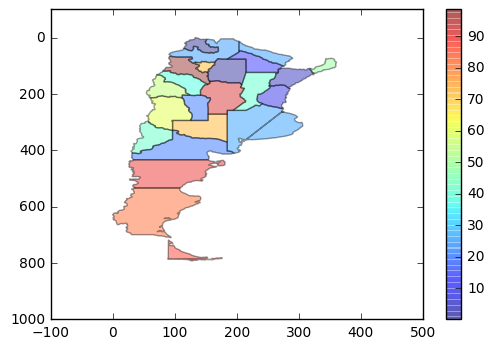

In [284]:
import numpy as np
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
patches = []
for points in polygons:
    polygon = Polygon(points, True)
    patches.append(polygon)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
ax.axis([-100, 500, 1000, -100])
fig.colorbar(p, ax=ax)

plt.show()